In [ ]:
!pip install timm scikit-learn matplotlib

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devasmitakundu","key":"f89943c77b9fa757e57172e12f3b69e2"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d shashwatwork/identifying-disease-in-tea-leafs

Dataset URL: https://www.kaggle.com/datasets/shashwatwork/identifying-disease-in-tea-leafs
License(s): CC-BY-SA-4.0
 96% 712M/740M [00:05<00:00, 301MB/s]
100% 740M/740M [00:05<00:00, 133MB/s]


In [ ]:
! unzip identifying-disease-in-tea-leafs

Archive:  identifying-disease-in-tea-leafs.zip
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143242.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143328.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143336.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143344.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143352.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143401.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143424.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143433.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143441.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143451.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143501.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143511.jpg  
  inflating: tea sickness dataset/Anthracnose/IMG_20220503_143525.jpg  
  inflating: tea 

In [ ]:
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),         # squish to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # normalize to [-1, 1]
])

dataset = ImageFolder(root="/content/tea sickness dataset", transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

# Split: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
import timm
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model(
    'convnext_small.in12k_ft_in1k',
    pretrained=False,
    num_classes=num_classes
)
model.to(device)

model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [ ]:
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# For plotting
train_loss_history = []
train_acc_history = []
train_f1_history = []
train_precision_history = []
train_recall_history = []

for epoch in range(20):  # change number of epochs as needed
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    train_f1_history.append(epoch_f1)
    train_precision_history.append(epoch_precision)
    train_recall_history.append(epoch_recall)

    print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}, F1={epoch_f1:.4f}, "
          f"Precision={epoch_precision:.4f}, Recall={epoch_recall:.4f}")


Epoch 1: Loss=1.8932, Acc=0.2528, F1=0.2563, Precision=0.2871, Recall=0.2528
Epoch 2: Loss=0.9447, Acc=0.5960, F1=0.5875, Precision=0.5898, Recall=0.5960
Epoch 3: Loss=0.5861, Acc=0.7542, F1=0.7530, Precision=0.7574, Recall=0.7542
Epoch 4: Loss=0.3621, Acc=0.8432, F1=0.8442, Precision=0.8461, Recall=0.8432
Epoch 5: Loss=0.2003, Acc=0.9308, F1=0.9305, Precision=0.9311, Recall=0.9308
Epoch 6: Loss=0.1295, Acc=0.9576, F1=0.9574, Precision=0.9581, Recall=0.9576
Epoch 7: Loss=0.1406, Acc=0.9548, F1=0.9548, Precision=0.9555, Recall=0.9548
Epoch 8: Loss=0.1069, Acc=0.9619, F1=0.9618, Precision=0.9620, Recall=0.9619
Epoch 9: Loss=0.0534, Acc=0.9816, F1=0.9816, Precision=0.9817, Recall=0.9816
Epoch 10: Loss=0.0565, Acc=0.9816, F1=0.9817, Precision=0.9818, Recall=0.9816
Epoch 11: Loss=0.0592, Acc=0.9873, F1=0.9873, Precision=0.9875, Recall=0.9873
Epoch 12: Loss=0.2553, Acc=0.9195, F1=0.9193, Precision=0.9191, Recall=0.9195
Epoch 13: Loss=0.1357, Acc=0.9393, F1=0.9393, Precision=0.9405, Recall=0.

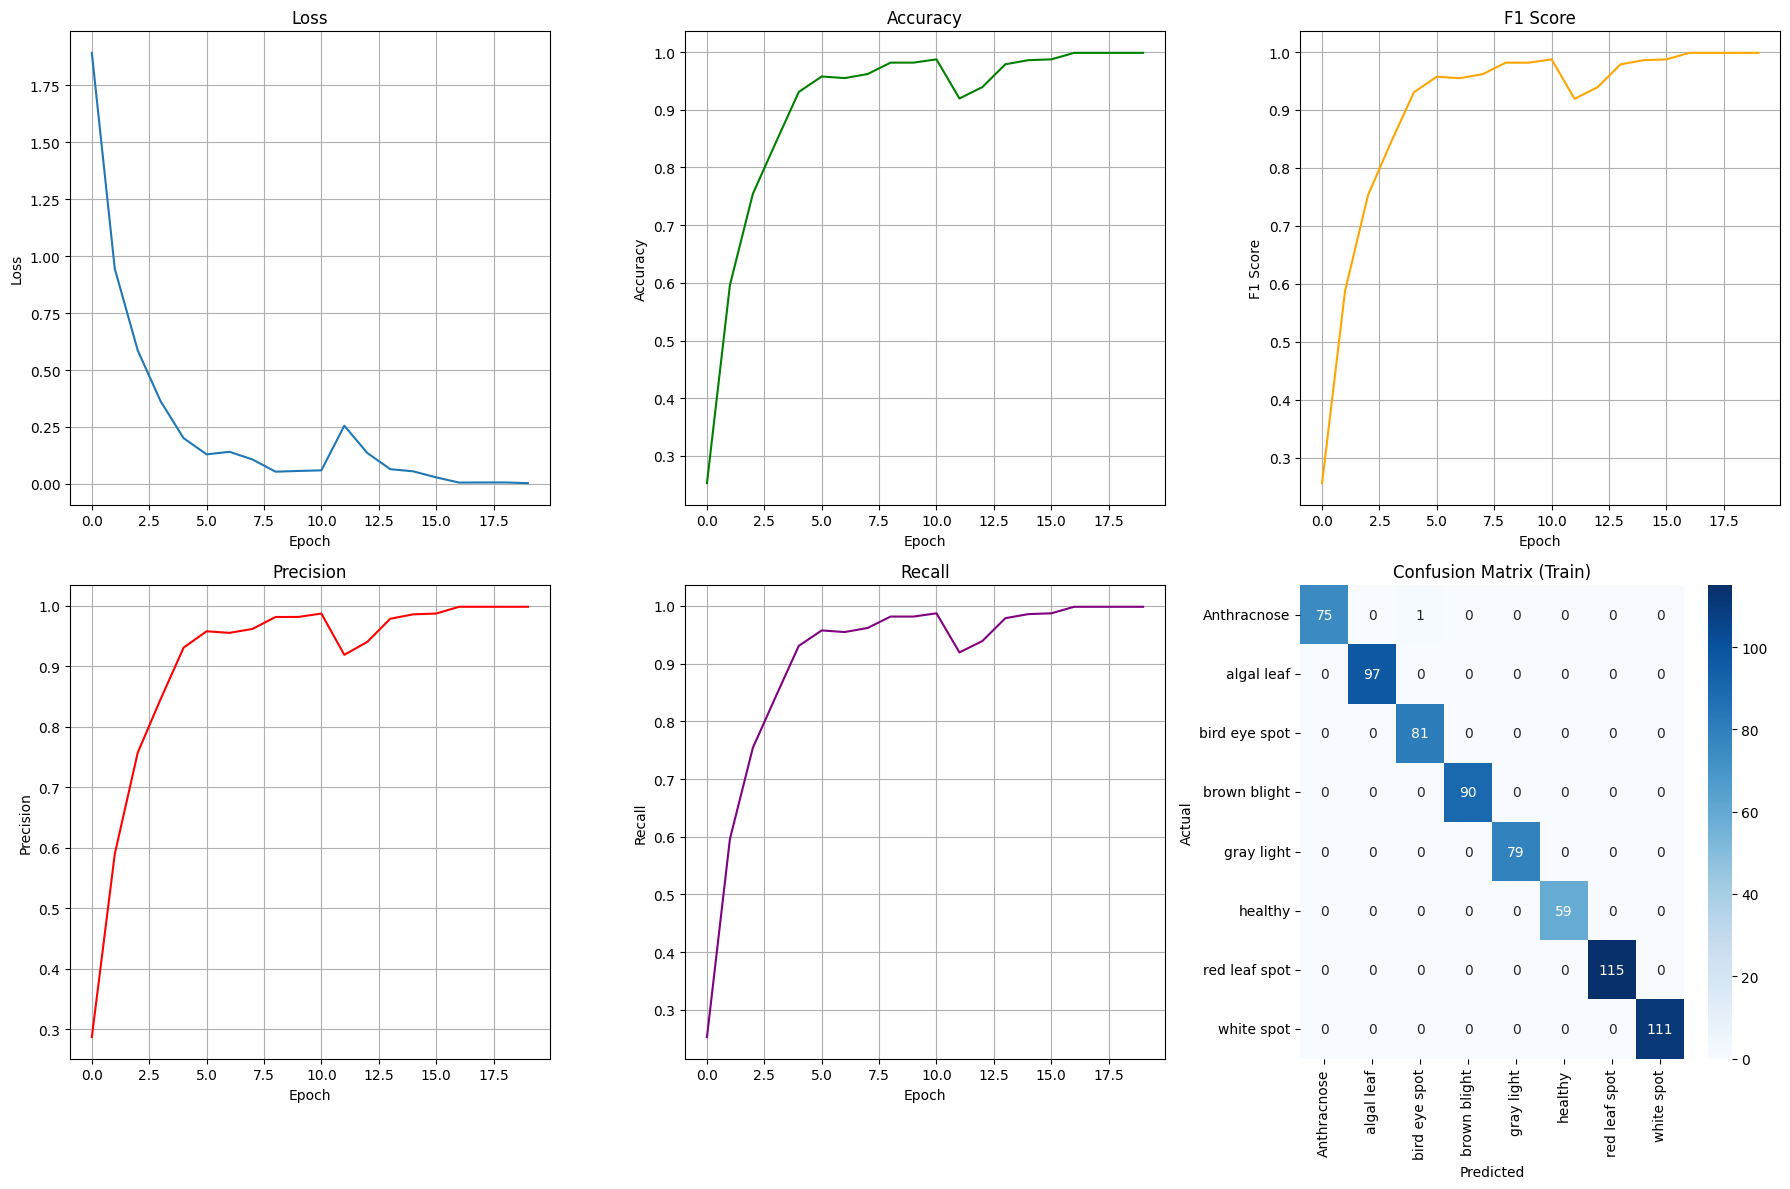

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training metrics
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(train_loss_history, label="Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

plt.subplot(2, 3, 2)
plt.plot(train_acc_history, label="Accuracy", color='green')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

plt.subplot(2, 3, 3)
plt.plot(train_f1_history, label="F1 Score", color='orange')
plt.title("F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid()

plt.subplot(2, 3, 4)
plt.plot(train_precision_history, label="Precision", color='red')
plt.title("Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.grid()

plt.subplot(2, 3, 5)
plt.plot(train_recall_history, label="Recall", color='purple')
plt.title("Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.grid()

# Generate confusion matrix from last epoch training data
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.subplot(2, 3, 6)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Train)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Test Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Test Accuracy: 0.8983, F1: 0.8995, Precision: 0.9024, Recall: 0.8983


In [ ]:
save_path = "convnext_leaf_model.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': class_names  # Save label mapping too
}, save_path)

print(f"Model saved to {save_path}")

Model saved to convnext_leaf_model.pth


In [ ]:
!pip show torch

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [ ]:
!pip show torchvision

Name: torchvision
Version: 0.21.0+cu124
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, pillow, torch
Required-by: fastai, timm


In [ ]:
!pip show timm

Name: timm
Version: 1.0.15
Summary: PyTorch Image Models
Home-page: https://github.com/huggingface/pytorch-image-models
Author: 
Author-email: Ross Wightman <ross@huggingface.co>
License: Apache-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: huggingface_hub, pyyaml, safetensors, torch, torchvision
Required-by: 


In [ ]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYR

In [ ]:
!pip show matplotlib

Name: matplotlib
Version: 3.10.0
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: Unknown <matplotlib-users@python.org>
License: License agreement for matplotlib versions 1.3.0 and later

 1. This LICENSE AGREEMENT is between the Matplotlib Development Team
 ("MDT"), and the Individual or Organization ("Licensee") accessing and
 otherwise using matplotlib software in source or binary form and its
 associated documentation.

 2. Subject to the terms and conditions of this License Agreement, MDT
 hereby grants Licensee a nonexclusive, royalty-free, world-wide license
 to reproduce, analyze, test, perform and/or display publicly, prepare
 derivative works, distribute, and otherwise use matplotlib
 alone or in any derivative version, provided, however, that MDT's
 License Agreement and MDT's notice of copyright, i.e., "Copyright (c)
 2012- Matplotlib Development Team; All Rights Reserved" are retained in
 matplotlib

In [ ]:
cat = ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']

In [ ]:
model_cfg = {
    "label_names": cat
}

In [ ]:
timm.models.push_to_hf_hub(model,"convnext-tea-v2",model_config=model_cfg, commit_message="Upload trained tea leaf disease ConvNeXt model v2")

model.safetensors:   0%|          | 0.00/198M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/198M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Luna-Skywalker/convnext-tea-v2/commit/406adec1561ce9f21344c9f845786f849e33974c', commit_message='Upload trained tea leaf disease ConvNeXt model v2', commit_description='', oid='406adec1561ce9f21344c9f845786f849e33974c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Luna-Skywalker/convnext-tea-v2', endpoint='https://huggingface.co', repo_type='model', repo_id='Luna-Skywalker/convnext-tea-v2'), pr_revision=None, pr_num=None)